In [ ]:
#Step1: Import the Housing data

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


housing = pd.read_csv('housing.csv')

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [ ]:
#Step2: Check for the missing data in the Dataframe
housing.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [ ]:
#step4:Split the data in training and test set

# below i have used StratifiedShuffleSplit to split the data.
# for the Assignment i am goi g to used this split mechanisum as it is best in case of MultipleSplits and Cross Validation is in picture.

housing['income_group'] = pd.cut(housing['median_income'],bins= [0.,1.5,3,4.5,6,np.inf], labels= [1,2,3,4,5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_group"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
housing = strat_train_set.drop(["median_house_value",'income_group'], axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

#Creating Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
         ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#Fine-Tunning the model

# Fine Tunning the Linear regression using grid and randomised seach



In [ ]:
# Fine-tuning with GridSearch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}


# Grid search
ln_grid = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
ln_grid.fit(housing_prepared, housing_labels)

print("Best Parameters:", ln_grid.best_params_)
print("Best CV Score:", -ln_grid.best_score_)


Best Parameters: {'copy_X': True, 'fit_intercept': True}
Best CV Score: 4791669824.226568


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494763
Standard deviation: 2372.070791055922


## Fine Tunning the Decission regression using grid and randomised seach


In [ ]:
# Fine-tuning with GridSearch for Decision Tree

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint


param_grid_tree = {
    'max_depth': list(range(1, 20)),
    'min_samples_leaf': list(range(1, 20))
}

# param_grid_tree = {
#     'max_depth': randint(low=1, high=20),
#     'min_samples_leaf': randint(low=1, high=20),
#     'min_samples_leaf': randint(low=1, high=20)
# }

tree_grid_reg = DecisionTreeRegressor(random_state=42)
tree_grid_reg.fit(housing_prepared, housing_labels)

grid_DT = GridSearchCV(tree_grid_reg, param_grid_tree, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_DT.fit(housing_prepared, housing_labels)


print("Best Parameters:", grid_DT.best_params_)
print("Best CV Score:", -grid_DT.best_score_)

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 12}
Best CV Score: 3366140091.1898565


In [ ]:
tree_grid_reg_best=DecisionTreeRegressor(max_depth=15,min_samples_leaf=12,random_state=42)
scores = cross_val_score(tree_grid_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
dt_rmse_grid_scores = np.sqrt(-scores)
display_scores(dt_rmse_grid_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


In [ ]:
# Fine-tuning with RandomisedSearch for Decision Tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

param_grid_tree = {
    'max_depth': randint(low=1, high=20),
    'min_samples_leaf': randint(low=1, high=20)
}

tree_ran_reg = DecisionTreeRegressor(random_state=42)
tree_ran_reg.fit(housing_prepared, housing_labels)

grid_DT = RandomizedSearchCV(tree_ran_reg, param_grid_tree, n_iter=10, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_DT.fit(housing_prepared, housing_labels)


print("Best Parameters:", grid_DT.best_params_)
print("Best CV Score:", -grid_DT.best_score_)

Best Parameters: {'max_depth': 18, 'min_samples_leaf': 18}
Best CV Score: 3455055685.0556817


In [ ]:
tree_ran_reg_best=DecisionTreeRegressor(max_depth=18,min_samples_leaf=18,random_state=42)
scores = cross_val_score(tree_ran_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
dt_rmse_rad_scores = np.sqrt(-scores)
display_scores(dt_rmse_rad_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


## Fine Tunning the Randomised regression using grid and randomised seach






In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]


forest_reg = RandomForestRegressor(random_state=42)

Far_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
Far_grid_search.fit(housing_prepared, housing_labels)

forest_reg.fit(housing_prepared, housing_labels)

print("Best Parameters:", Far_grid_search.best_params_)
print("Best CV Score:", -Far_grid_search.best_score_)

Best Parameters: {'max_features': 8, 'n_estimators': 30}
Best CV Score: 2494115002.1567564


In [ ]:
Far_grid_search_best=RandomForestRegressor(max_features=8,n_estimators=30,random_state=42)
scores = cross_val_score(Far_grid_search_best, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_grid_scores = np.sqrt(-scores)
display_scores(tree_rmse_grid_scores)

Scores: [50316.75625812 49166.08712273 45882.61020515 51532.22359723
 48344.25260687 49993.18750725 51676.78223282 49750.42780473
 47864.33303225 53329.8002785 ]
Mean: 49785.64606456555
Standard deviation: 2022.39835494758


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]


forest_ran_reg = RandomForestRegressor(random_state=42)

Far_ran_search = RandomizedSearchCV(forest_ran_reg, param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
Far_ran_search.fit(housing_prepared, housing_labels)


print("Best Parameters:", Far_ran_search.best_params_)
print("Best CV Score:", -Far_ran_search.best_score_)

Best Parameters: {'n_estimators': 30, 'max_features': 8}
Best CV Score: 2494115002.1567564


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

Far_ran_search_best=RandomForestRegressor(max_features=8,n_estimators=30,random_state=42)
scores = cross_val_score(Far_ran_search, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_rad_scores = np.sqrt(-scores)
display_scores(tree_rmse_rad_scores)

Scores: [51291.24909772 48524.53380971 46366.24028525 51532.22359723
 48344.25260687 49655.023849   51676.78223282 49665.64807308
 48209.72560292 53803.57987381]
Mean: 49906.925902840325
Standard deviation: 2067.989742891886


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data: model names and their RMSE values
models = ['Random_regression_grid', 'Random_regression_randomised']
rmse_values = [
    np.mean(tree_rmse_grid_scores),
    np.mean(tree_rmse_rad_scores)
]

# Find the index of the best model (lowest RMSE)
best_idx = np.argmin(rmse_values)
best_model = models[best_idx]
best_rmse = rmse_values[best_idx]

print(f"The best model is '{best_model}' with RMSE = {best_rmse:.4f}")


# # Create a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x=models, y=rmse_values, palette='viridis')

# # Highlight the best model by annotating
# plt.text(best_idx, best_rmse + 0.1, f'Best: {best_model}',
#          ha='center', va='bottom', fontweight='bold', color='red')

# plt.title('RMSE Comparison Across Models')
# plt.xlabel('Models')
# plt.ylabel('RMSE')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


The best model is 'Random_regression_grid' with RMSE = 49785.6461


## Fine Tunning the SVR using grid and randomised search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


param_grid = [
         {'kernel': ['linear'], 'C': [100, 300, 1000, 3000, 5000]},
         {'kernel': ['rbf'], 'C': [100, 300, 1000, 3000, 5000],
          'gamma': [0.3, 1.0, 3.0, 10, 30]},
     ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...............................C=100, kernel=linear; total time=   9.7s
[CV] END ...............................C=100, kernel=linear; total time=  10.9s
[CV] END ...............................C=100, kernel=linear; total time=  11.3s
[CV] END ...............................C=100, kernel=linear; total time=  10.9s
[CV] END ...............................C=100, kernel=linear; total time=  10.7s
[CV] END ...............................C=300, kernel=linear; total time=  10.2s
[CV] END ...............................C=300, kernel=linear; total time=  10.0s
[CV] END ...............................C=300, kernel=linear; total time=  11.1s
[CV] END ...............................C=300, kernel=linear; total time=  10.8s
[CV] END ...............................C=300, kernel=linear; total time=  10.7s
[CV] END ..............................C=1000, kernel=linear; total time=  10.8s
[CV] END ..............................C=1000, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [100, 300, 1000, 3000, 5000],
                          'kernel': ['linear']},
                         {'C': [100, 300, 1000, 3000, 5000],
                          'gamma': [0.3, 1.0, 3.0, 10, 30],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(64228.35873420696)

In [ ]:
grid_search.best_params_

{'C': 5000, 'gamma': 0.3, 'kernel': 'rbf'}

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


svm_reg_rbf = SVR(kernel="rbf", C=5000)
svm_reg_rbf.fit(housing_prepared, housing_labels)

svm_rbf_scores = cross_val_score(svm_reg_rbf, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svm_rbf_rmse_scores = np.sqrt(-svm_rbf_scores)
display_scores(svm_rbf_rmse_scores)

Scores: [65631.10829286 60638.95892793 57832.98260855 64870.4434137
 59574.88516553 65736.18690622 65573.41214906 62628.23263111
 61701.99368265 64346.41780128]
Mean: 62853.46215788871
Standard deviation: 2682.453959801877


In [24]:
#ramdomisedSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR


param_grid = {
    'kernel': ['linear','rbf'],
    'C': [7000, 10000, 20000, 30000, 40000],
    'gamma': [0.1, 0.3, 1.0, 3.0 ],
}

svm_reg_rsv = SVR()
rsv_search = RandomizedSearchCV(svm_reg_rsv, param_grid, n_iter=10,cv=5, scoring='neg_mean_squared_error', verbose=2)
rsv_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................C=7000, gamma=3.0, kernel=linear; total time=  11.6s
[CV] END ...................C=7000, gamma=3.0, kernel=linear; total time=  11.9s
[CV] END ...................C=7000, gamma=3.0, kernel=linear; total time=  12.5s
[CV] END ...................C=7000, gamma=3.0, kernel=linear; total time=  11.2s
[CV] END ...................C=7000, gamma=3.0, kernel=linear; total time=  11.5s
[CV] END .....................C=40000, gamma=0.1, kernel=rbf; total time=  15.7s
[CV] END .....................C=40000, gamma=0.1, kernel=rbf; total time=  14.4s
[CV] END .....................C=40000, gamma=0.1, kernel=rbf; total time=  14.3s
[CV] END .....................C=40000, gamma=0.1, kernel=rbf; total time=  14.3s
[CV] END .....................C=40000, gamma=0.1, kernel=rbf; total time=  14.3s
[CV] END .....................C=20000, gamma=0.1, kernel=rbf; total time=  13.8s
[CV] END .....................C=20000, gamma=0.1

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [7000, 10000, 20000, 30000, 40000],
                                        'gamma': [0.1, 0.3, 1.0, 3.0],
                                        'kernel': ['linear', 'rbf']},
                   scoring='neg_mean_squared_error', verbose=2)

In [25]:
negative_mse = rsv_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(58748.26606200322)

In [26]:
rsv_search.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'C': 40000}

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


svm_reg_rsv = SVR(kernel="rbf", C=40000)
svm_reg_rsv.fit(housing_prepared, housing_labels)

svm_reg_rsv_scores = cross_val_score(svm_reg_rsv, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svm_reg_rsv_rmse_scores = np.sqrt(-svm_reg_rsv_scores)
display_scores(svm_reg_rsv_rmse_scores)

Scores: [61193.09120243 55980.61993707 53435.513585   59915.43184854
 54668.08588348 60817.91672242 60495.33546082 57839.62732272
 56709.84302947 60598.58835038]
Mean: 58165.40533423332
Standard deviation: 2687.2931480230272


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data: model names and their RMSE values
models = ['Linear_regression', 'Decision_Tree','RandomisedForest', 'SVM']
rmse_values = [
    np.mean(lin_rmse_scores),
    np.mean(dt_rmse_rad_scores),
    np.mean(tree_rmse_grid_scores),
    np.mean(svm_reg_rsv_rmse_scores)
]

# Find the index of the best model (lowest RMSE)
best_idx = np.argmin(rmse_values)
best_model = models[best_idx]
best_rmse = rmse_values[best_idx]

print(f"The best model is '{best_model}' with RMSE = {best_rmse:.4f}")

df_results = pd.DataFrame({
    "Model": models,
    "RMSE": rmse_values
})


The best model is 'RandomisedForest' with RMSE = 49785.6461


In [36]:
display(df_results)

,Model,RMSE
0,Linear_regression,69204.322755
1,Decision_Tree,69081.361563
2,RandomisedForest,49785.646065
3,SVM,58165.405334


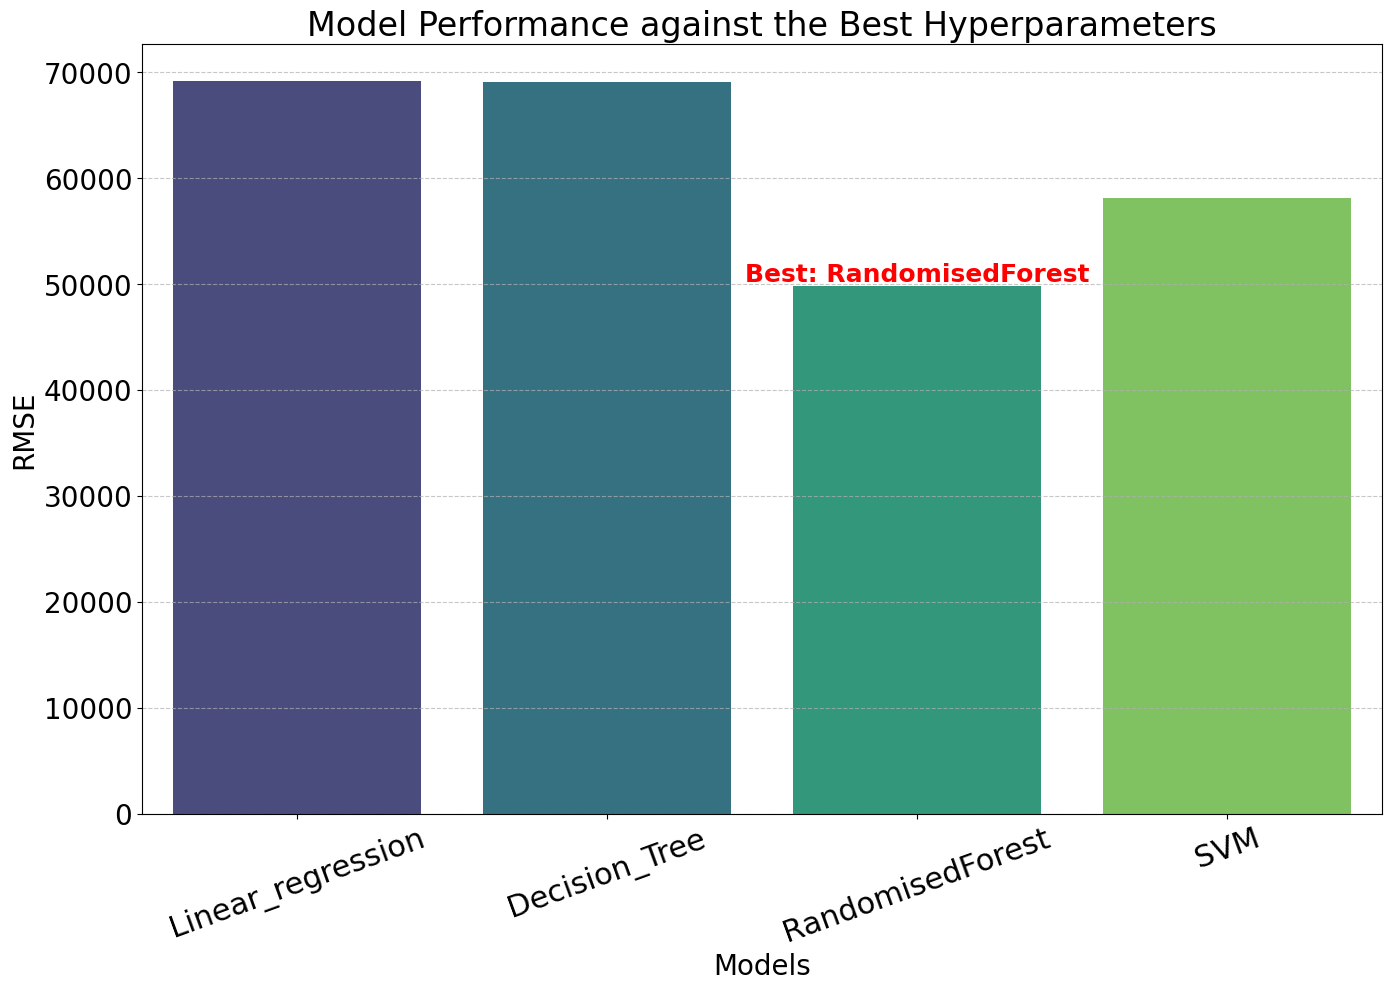

In [57]:
# Create a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x=models, y=rmse_values, palette='viridis')

# # Highlight the best model by annotating
# plt.text(best_idx, best_rmse + 0.1, f'Best: {best_model}',
#          ha='center', va='bottom', fontweight='bold', color='red')

# plt.title('RMSE Comparison Across Models')
# plt.xlabel('Models')
# plt.ylabel('RMSE')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()



# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x=models, y=rmse_values, hue=models, palette='viridis', legend=False)

# # Highlight the best model by annotating
# plt.text(best_idx, best_rmse + 0.1, f'Best: {best_model}',
#          ha='center', va='bottom', fontweight='bold', color='red')

# plt.title('Model Performance against the best hyperparameters')
# plt.xlabel('Models')
# plt.ylabel('RMSE')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# import matplotlib.pyplot as plt
# import seaborn as sns

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Example data: model names and their RMSE values
# models = ['Linear_regression', 'Decision_Tree',' RandomisedForest', 'SVM']
# rmse_values = [
#     np.mean(lin_rmse_scores),
#     np.mean(dt_rmse_rad_scores),
#     np.mean(tree_rmse_grid_scores),
#     np.mean(svm_reg_rsv_rmse_scores)
# ]

# # Create a larger bar plot
# plt.figure(figsize=(24, 15))  # Increase the size here
# sns.barplot(x=models, y=rmse_values, hue=models, palette='viridis', legend=False)

# # Highlight the best model by annotating
# plt.text(best_idx, best_rmse + 0.1, f'Best: {best_model}',
#          ha='center', va='bottom', fontweight='bold', color='red')

# plt.title('Model Performance against the best hyperparameters', fontsize=20)  # larger title
# plt.xlabel('Models', fontsize=16)  # larger x-label
# plt.ylabel('RMSE', fontsize=16)  # larger y-label
# plt.xticks(fontsize=14)  # larger x-tick labels
# plt.yticks(fontsize=14)  # larger y-tick labels
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


models = ['Linear_regression', 'Decision_Tree','RandomisedForest', 'SVM']
rmse_values = [
    np.mean(lin_rmse_scores),
    np.mean(dt_rmse_rad_scores),
    np.mean(tree_rmse_grid_scores),
    np.mean(svm_reg_rsv_rmse_scores)
]

# Find the best model
best_idx = np.argmin(rmse_values)
best_rmse = rmse_values[best_idx]
best_model = models[best_idx]

# Create a larger bar plot
plt.figure(figsize=(16, 10))  # bigger figure
sns.barplot(x=models, y=rmse_values, hue=models, palette='viridis', legend=False)

# Highlight the best model by annotating
plt.text(best_idx, best_rmse + 0.1, f'Best: {best_model}',
         ha='center', va='bottom', fontweight='bold', color='red', fontsize=18)

# Increase font size for title, labels, and ticks
plt.title('Model Performance against the Best Hyperparameters', fontsize=24)
plt.xlabel('Models', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.xticks(fontsize=22, rotation=20)  # bigger model names
plt.yticks(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#Evaluatig the best Model on Testset data

In [40]:

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(61196.92192049741)

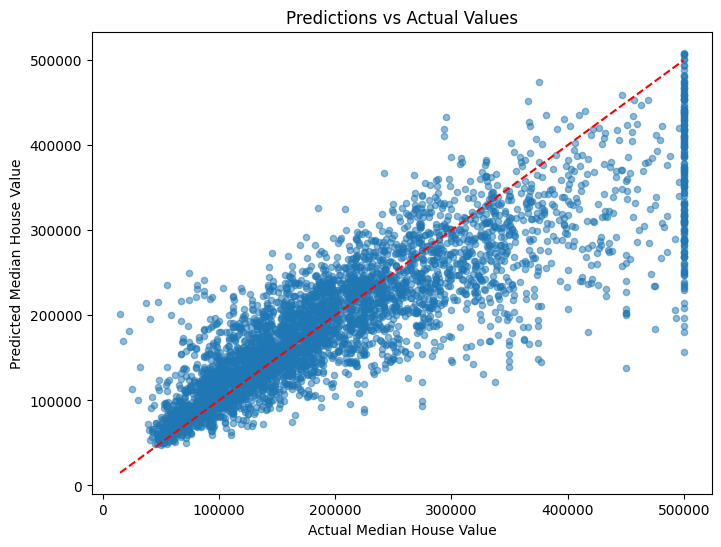

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # diagonal line
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Predictions vs Actual Values")
plt.show()